# Software Requirements Classification
## Logistic Regression

### Data Preprocessing

In [645]:
import pandas as pd

df = pd.read_csv('software_requirements_extended.csv')
df.head()

,Type,Requirement
0,PE,The system shall refresh the display every 60 ...
1,LF,The application shall match the color of the s...
2,US,If projected the data must be readable. On ...
3,A,The product shall be available during normal ...
4,US,If projected the data must be understandable...


In [646]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Type         977 non-null    object
 1   Requirement  977 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


In [647]:
import plotly.express as px

# draw a pie chart of the different sentiments of the posts
fig = px.pie(df, names='Type', title ='Types of requirements')
fig.show()

data set is small and not balanced to write a model to predict all the types of requirements. but its enough and balanced to predict if type is functional or non-functional

In [648]:
df['Type'] = df['Type'].apply(lambda x: 1 if x == 'FR' or x == 'F' else 0)
fig = px.pie(df, names='Type', title ='Pie of types of requirements')
fig.show()

#### Trying to find some patterns in the data

In [649]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to preprocess text and generate word cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


Word Cloud for Functional Requirements


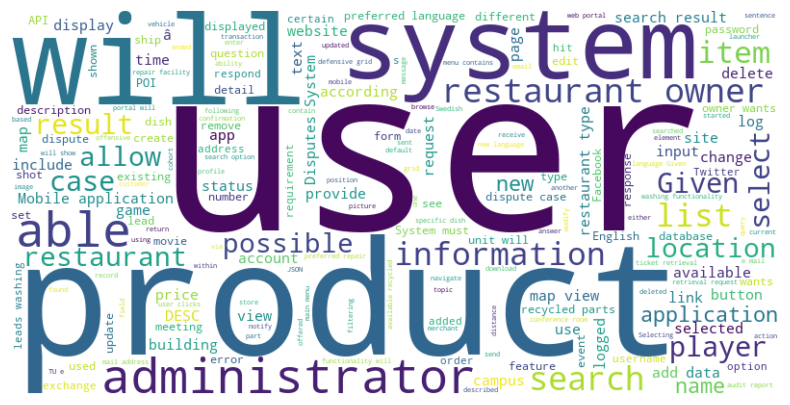

Word Cloud for Non-Functional Requirements


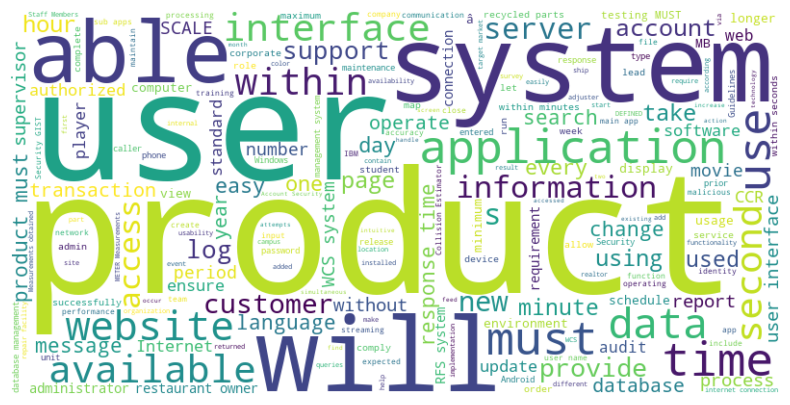

In [650]:
# Separate the requirements by type
functional_requirements = ' '.join(df[df['Type'] == 1]['Requirement'])
non_functional_requirements = ' '.join(df[df['Type'] == 0]['Requirement'])

# Generate and display word clouds
print("Word Cloud for Functional Requirements")
generate_wordcloud(functional_requirements)

print("Word Cloud for Non-Functional Requirements")
generate_wordcloud(non_functional_requirements)


In [651]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [652]:
# Pre-load stopwords to improve efficiency
STOPWORDS = set(stopwords.words("english"))

# Expanded pattern to potentially keep useful punctuation or additional cleaning
pattern_without_numbers = re.compile(r"[^a-zA-Z]")
pattern_with_numbers = re.compile(r"[^\w\d]")

def req_to_words(req, delete_stopwords, with_numbers, normalize_numbers,lemmatize = False,stemming = False,):
    """Convert requirement text into a sequence of 'clean' words"""
    # Convert to lower case
    text = req.lower()
    
    if with_numbers:
        pattern = pattern_with_numbers
    else:
        pattern = pattern_without_numbers
    
    if with_numbers and normalize_numbers:
        text = re.sub(r'\b\d+\b', 'num', text)
    
    # Remove unwanted characters
    text = re.sub(pattern, " ", text)
    
    # Tokenize
    words = text.split()
    
    # Remove stopwords
    if delete_stopwords:
        words = [w for w in words if w not in STOPWORDS]

    # Apply lemmatization or stemming
    if lemmatize:
        words = [ WordNetLemmatizer().lemmatize(w) for w in words]
    elif stemming: # Stemming
        words = [PorterStemmer().stem(w) for w in words]
        
    # join the words back into one string
    clean_req = " ".join(words)
        
    return clean_req

In [653]:
# Example use
print("\nOriginal requirement:", df['Requirement'][0])
print("\nWithout stopwords:", req_to_words(df['Requirement'][0], delete_stopwords=True, with_numbers=True, normalize_numbers=False))
print("\nWith normalized numbers:", req_to_words(df['Requirement'][0], delete_stopwords=False, with_numbers=True, normalize_numbers=True))
print("\nWithout numbers:", req_to_words(df['Requirement'][0], delete_stopwords=False, with_numbers=False, normalize_numbers=False))
print("\nWith lemmatization:", req_to_words(df['Requirement'][0], delete_stopwords=False, with_numbers=False, normalize_numbers=True, lemmatize=True))
print("\nWith stemming:", req_to_words(df['Requirement'][0], delete_stopwords=False, with_numbers=False, normalize_numbers=True, stemming=True))
print("\nMost clean:", req_to_words(df['Requirement'][0], delete_stopwords=True, with_numbers=False, normalize_numbers=False, stemming=True))


Original requirement: The system shall refresh the display every 60 seconds.

Without stopwords: system shall refresh display every 60 seconds

With normalized numbers: the system shall refresh the display every num seconds

Without numbers: the system shall refresh the display every seconds

With lemmatization: the system shall refresh the display every second

With stemming: the system shall refresh the display everi second

Most clean: system shall refresh display everi second


In [654]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

### Model

In [668]:
import warnings
from sklearn.model_selection import GridSearchCV

def find_best_hyperparameters(X,y):
    # suppress warnings
    warnings.filterwarnings('ignore')
    with warnings.catch_warnings():
        # Ignore specific warnings
        warnings.simplefilter("ignore", UserWarning)
        warnings.simplefilter("ignore", FutureWarning)
    
    # looking for the best hyperparameters
    # Define the model
    model = LogisticRegression()

    # Define a grid of hyperparameters to search
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  # Values for C
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Types of penalty
        'solver': ['liblinear', 'lbfgs', 'saga'],  # Solvers
        'max_iter': [100, 200, 300]  # Maximum iterations
    }
    
    # Setup the grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    
    # Fit the grid search to the data
    grid_search.fit(X, y)
    
    # Print the best parameters and the best score
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    return grid_search.best_params_, grid_search.best_score_

In [656]:
import matplotlib.pyplot as plt

def draw_important_features(model, vectorizer):
    # Get the coefficients 
    feature_importances = model.coef_[0]
    
    # Get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Zip feature importances with names and create a DataFrame
    importance_df = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=['Feature', 'Importance'])
    
    # Sort the DataFrame by the absolute values of the Importance column
    importance_df = importance_df.reindex(importance_df.Importance.abs().sort_values(ascending=False).index)
    
    # Plot the top 10 features
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
    plt.xlabel('Coefficient Value')
    plt.title('Top 10 Features')
    plt.show()

In [657]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def draw_confusion_matrix(y_test, y_pred):
    # Compute the normalized confusion matrix
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
    
    # Convert to percentage
    cm_percentage = cm_normalized * 100
    
    # Visualize the confusion matrix as percentages
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Functional', 'Functional'], yticklabels=['Non-Functional', 'Functional'])
    plt.title('Confusion Matrix (Percentage)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [658]:
def run_experiment(df, preprocessing_params, isVisualize = True):
    """
    Run an experiment to train a logistic regression model with the best hyperparameters found using grid search.
    Evaluates the model using cross-validation and on a test set, and displays the model's important features and confusion matrix.

    Parameters:
    - df: DataFrame containing the dataset.
    - preprocessing_params: Dictionary containing preprocessing parameters (lemmatize, delete_stopwords, normalize_numbers, etc.).
    - ngram_range: Tuple indicating the range of n-grams to be used in vectorization.
    """
    # Extract preprocessing parameters
    lemmatize = preprocessing_params.get('lemmatize', False)
    stemming = preprocessing_params.get('stemming', False)
    delete_stopwords = preprocessing_params.get('delete_stopwords', True)
    with_numbers = preprocessing_params.get('with_numbers', True)
    normalize_numbers = preprocessing_params.get('normalize_numbers', True)

    # Prepare the data
    y = df['Type']
    # Preprocess the requirements to convert them into 'clean' words
    X = [req_to_words(req, lemmatize=lemmatize,stemming= stemming, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]


    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Vectorize the text
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Find the best model parameters
    best_params, best_cross = find_best_hyperparameters(X_train, y_train)
    
    # Create the best estimator
    best_estimator = LogisticRegression(**best_params)

    # Train the best estimator on the full training set
    best_estimator.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    if isVisualize:
        print(f'Accuracy: {test_accuracy * 100:.2f}%')

        # Detailed performance report
        print(classification_report(y_test, y_pred))
    
        # Additional evaluations
        draw_important_features(best_estimator, vectorizer)
        draw_confusion_matrix(y_test, y_pred)

    return best_estimator, vectorizer, best_cross

### Experimenting

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'C': 1, 'max_iter': 300, 'penalty': 'none', 'solver': 'saga'}
Best score: 0.8770824388149421
Accuracy: 86.39%
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       131
           1       0.88      0.88      0.88       163

    accuracy                           0.86       294
   macro avg       0.86      0.86      0.86       294
weighted avg       0.86      0.86      0.86       294


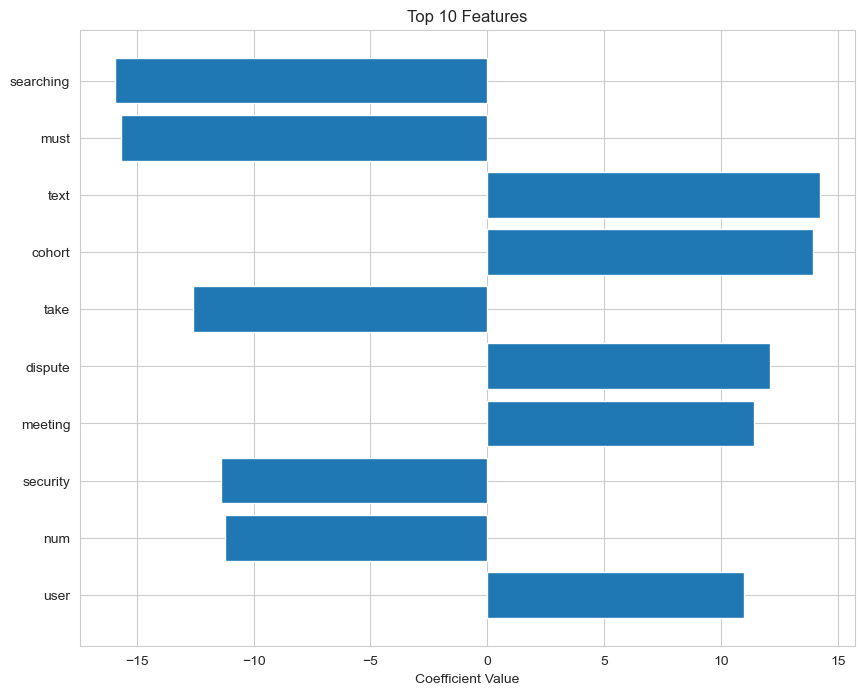

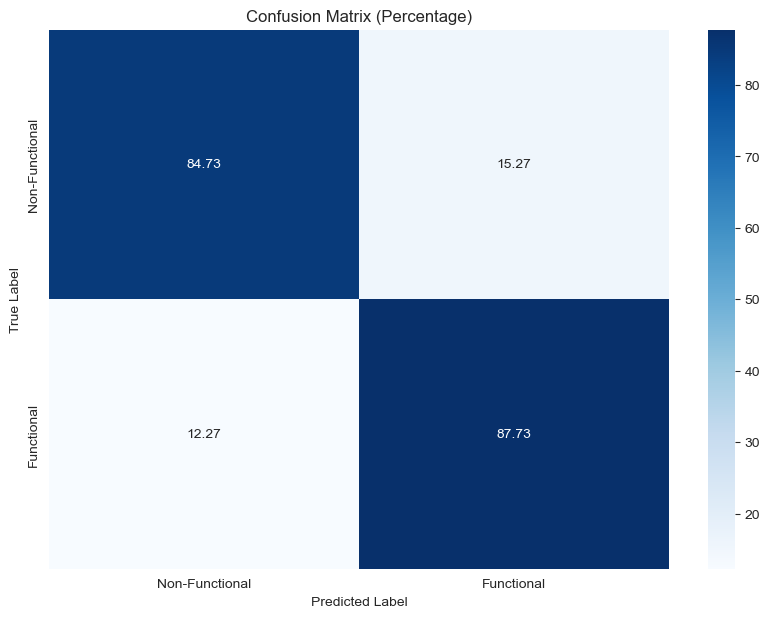

In [669]:
preprocessing_params = {
    'lemmatize': True, # use lemmatization false by default
    'stemming': False, # use stemming false by default
    'delete_stopwords': True, # delete stopwords like 'the', 'and', etc.
    'with_numbers': True, # keep numbers or not
    'normalize_numbers': True # normalize numbers to a single token (will only work if with_numbers is True)
}
model, vectorizer, cross = run_experiment(df, preprocessing_params)


In [660]:
from itertools import product

def find_best_cleaning_params(df):
    """
    Try all combinations of cleaning parameters and return the combination
    with the highest cross-validation score.
    """
    best_score = 0
    best_params = {}

    # Generate all possible combinations of boolean values for the parameters
    # There are five parameters, so there are 2^5 = 32 possible combinations
    for lemmatize, stemming, delete_stopwords, with_numbers, normalize_numbers in product([True, False], repeat=5):

        # Skip invalid combinations where we attempt to normalize numbers when they are not included
        if normalize_numbers and not with_numbers:
            continue

        # Set up the preprocessing parameters
        preprocessing_params = {
            'lemmatize': lemmatize,
            'stemming': stemming,
            'delete_stopwords': delete_stopwords,
            'with_numbers': with_numbers,
            'normalize_numbers': normalize_numbers
        }

        # Run the experiment with the current combination of parameters
        _, _, best_cross = run_experiment(df, preprocessing_params, isVisualize = False)

        # Update best score and parameters if current score is higher
        if best_cross > best_score:
            best_score = best_cross
            best_params = preprocessing_params

    return best_params, best_score

In [661]:
best_params, best_score = find_best_cleaning_params(df)
print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/skle

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklear

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `pena

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/en

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklear

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/skle

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalt

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/S

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs

Best parameters: {'lemmatize': True, 'stemming': False, 'delete_stopwords': True, 'with_numbers': True, 'normalize_numbers': True}
Best cross-validation score: 0.877082438814942


### Manually testing the model
Using my own examples to see how the model performs on them instead of using the test set

In [662]:
def predict_req(req, expected, model, vectorizer, preprocessing_params):
    df = pd.DataFrame([req], columns=['Requirement'])
    
    lemmatize = preprocessing_params.get('lemmatize', True)
    delete_stopwords = preprocessing_params.get('delete_stopwords', True)
    with_numbers = preprocessing_params.get('with_numbers', True)
    normalize_numbers = preprocessing_params.get('normalize_numbers', True)

    X = [req_to_words(req, lemmatize=lemmatize, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]
    X = vectorizer.transform(X)

    prediction = model.predict(X)
    predicted_label = 'Functional' if prediction[0] == 1 else 'Non-Functional'
    success = predicted_label == expected

    return predicted_label, success


In [663]:
def summarize_predictions(examples, model, vectorizer , preprocessing_params):
    results = []
    for req, expected_label in examples:
        predicted_label, success = predict_req(req, expected_label, model, vectorizer, preprocessing_params)
        results.append({
            'Requirement': req,
            'Expected Label': expected_label,
            'Predicted Label': predicted_label,
            'Success': success
        })
    return pd.DataFrame(results)

In [664]:
examples = [
    ("The system shall provide a login form that accepts a username and password.", 'Functional'),
    ("The application must ensure that response times are less than 2 seconds under normal load conditions.", 'Non-Functional'),
    ("All user passwords shall be encrypted before saving to the database.", 'Functional'),
    ("The software should be compatible with the Windows 10 operating system.", 'Non-Functional'),
    ("The interface shall refresh when new data is available.", 'Functional'),
    ("The product shall comply with international accessibility standards.", 'Non-Functional'),
    ("Database backup shall occur every 24 hours automatically.", 'Functional'),
    ("The system shall support a minimum of 500 concurrent user connections.", 'Functional'),
    ("The system’s mean time to failure shall be at least 10,000 hours.", 'Non-Functional'),
    ("Users must be able to complete the primary workflow in less than three minutes.", 'Non-Functional'),
    ("User settings must be retained for at least one year without login.", 'Non-Functional'),
    ("The system must support multi-language interfaces.", 'Functional'),
    ("Ensure data integrity during transaction processing.", 'Functional'),
    ("The application should load the user dashboard within 3 seconds.", 'Non-Functional'),
    ("Support data export to CSV and PDF formats.", 'Functional'),
    ("Must be compatible with both iOS and Android operating systems.", 'Non-Functional'),
    ("Implement two-factor authentication for user logins.", 'Functional'),
    ("The application must be available 99.9% of the time.", 'Non-Functional'),
    ("Automatically log out users after 30 minutes of inactivity.", 'Functional'),
    ("The system must scale to support up to 10,000 users simultaneously.", 'Non-Functional'),
    ("Provide a way to recover forgotten passwords securely.", 'Functional'),
    ("The system must encrypt sensitive data both at rest and in transit.", 'Non-Functional'),
    ("Support for user roles including admin, editor, and viewer.", 'Functional'),
    ("Ensure the application interface adheres to the latest web accessibility guidelines.", 'Non-Functional'),
    ("The software must be installable on both Windows and MacOS.", 'Non-Functional'),
    ("Offer a search function that returns results within 2 seconds.", 'Functional'),
    ("The mobile app should use no more than 50MB of data per hour of activity.", 'Non-Functional'),
    ("The platform must integrate seamlessly with third-party email services.", 'Functional'),
    ("User feedback must be addressed and incorporated within two release cycles.", 'Non-Functional'),
    ("Provide detailed logging of user actions to support auditing requirements.", 'Functional')
]


In [665]:
summary = summarize_predictions(examples, model, vectorizer, preprocessing_params)
summary

,Requirement,Expected Label,Predicted Label,Success
0,The system shall provide a login form that acc...,Functional,Functional,True
1,The application must ensure that response time...,Non-Functional,Non-Functional,True
2,All user passwords shall be encrypted before s...,Functional,Non-Functional,False
3,The software should be compatible with the Win...,Non-Functional,Non-Functional,True
4,The interface shall refresh when new data is a...,Functional,Non-Functional,False
5,The product shall comply with international ac...,Non-Functional,Non-Functional,True
6,Database backup shall occur every 24 hours aut...,Functional,Non-Functional,False
7,The system shall support a minimum of 500 conc...,Functional,Non-Functional,False
8,The system’s mean time to failure shall be at ...,Non-Functional,Non-Functional,True
9,Users must be able to complete the primary wor...,Non-Functional,Non-Functional,True


In [666]:
fig = px.pie(summary, names='Success', title ='Success of the model on my examples')
fig.show()